# FocusGAN ECE 285 Final Project
based off: https://arxiv.org/pdf/1701.01081.pdf

## imports

In [1]:
import torch
from torch import nn
from torchvision.models import vgg16
import torch.optim as optim
from torch.autograd.variable import Variable
from torchvision import transforms
import torch_directml
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import glob
import os

device = torch_directml.device(torch_directml.default_device())

/home/eddieh00/anaconda3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


## Visualize CAT2000 Dataset

## Dataloader and Device Setup

In [2]:
class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.img_files = glob.glob(self.root_dir + '/*/*.jpg')

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = self.img_files[idx]
        image = Image.open(img_path).convert('RGB')  # Convert image to RGB
        if self.transform:
            image = self.transform(image)
        return image

class SaliencyMapDataset(Dataset):
    def __init__(self, root_dir, transform=None, map_transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.map_transform = map_transform
        self.img_files = glob.glob(self.root_dir + '/*/*.jpg')

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = self.img_files[idx]
        map_path = os.path.join(os.path.dirname(img_path), 'Output', os.path.basename(img_path).replace('.jpg', '_SaliencyMap.jpg'))

        image = Image.open(img_path).convert('RGB')  # Convert image to RGB
        saliency_map = Image.open(map_path).convert('L')  # Convert saliency map to grayscale

        if self.transform:
            image = self.transform(image)
        if self.map_transform:
            saliency_map = self.map_transform(saliency_map)

        return image, saliency_map



image_transform = transforms.Compose([
    transforms.Resize((256, 256)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

map_transform = transforms.Compose([
    transforms.Resize((256, 256)),  
    transforms.ToTensor()
])

batch_size = 1
saliency_map_dataset = SaliencyMapDataset(root_dir='./trainSet/Stimuli', transform=image_transform, map_transform=map_transform)
dataloader = DataLoader(saliency_map_dataset, batch_size=batch_size, shuffle=True)


## Generator

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        vgg = vgg16(pretrained=True)
        self.encoder = nn.Sequential(*list(vgg.features.children())[:-1]) # remove last pooling layer
        self.decoder = self.make_decoder()
        
    def make_decoder(self):
        decoder = nn.Sequential(
        nn.Conv2d(512, 512, kernel_size=3, padding=1),  # conv6_1
        nn.ReLU(),
        nn.Conv2d(512, 512, kernel_size=3, padding=1),  # conv6_2
        nn.ReLU(),
        nn.Conv2d(512, 512, kernel_size=3, padding=1),  # conv6_3
        nn.ReLU(),
        nn.Upsample(scale_factor=2),  # upsample6

        nn.Conv2d(512, 512, kernel_size=3, padding=1),  # conv7_1
        nn.ReLU(),
        nn.Conv2d(512, 512, kernel_size=3, padding=1),  # conv7_2
        nn.ReLU(),
        nn.Conv2d(512, 512, kernel_size=3, padding=1),  # conv7_3
        nn.ReLU(),
        nn.Upsample(scale_factor=2),  # upsample7

        nn.Conv2d(512, 256, kernel_size=3, padding=1),  # conv8_1
        nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size=3, padding=1),  # conv8_2
        nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size=3, padding=1),  # conv8_3
        nn.ReLU(),
        nn.Upsample(scale_factor=2),  # upsample8

        nn.Conv2d(256, 128, kernel_size=3, padding=1),  # conv9_1
        nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size=3, padding=1),  # conv9_2
        nn.ReLU(),
        nn.Upsample(scale_factor=2),  # upsample9

        nn.Conv2d(128, 64, kernel_size=3, padding=1),  # conv10_1
        nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=3, padding=1),  # conv10_2
        nn.ReLU(),

        nn.Conv2d(64, 1, kernel_size=1),  # output
        nn.Sigmoid()
        )
        
        return decoder

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        #this first layer is needed for training. In training, the images and saliency maps
        #are concatenated so we get a 4 channel input rataher than 3 chanel rgb
        self.first_layer = nn.Conv2d(4, 64, kernel_size=3, stride=2, padding=1)
        self.conv_layers = self.make_conv_layers()
        self.fc_layers = self.make_fc_layers()

    def make_conv_layers(self):
        conv_layers = nn.Sequential(
            nn.Conv2d(3, 3, kernel_size= 1, padding=1),
            nn.ReLU(),
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(stride=2, kernel_size=2, padding=0),

            nn.Conv2d(32, 64, kernel_size= 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(stride=2, kernel_size=2, padding=0),

            nn.Conv2d(64, 64, kernel_size= 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(stride=2, kernel_size=2, padding=0)
        )
        return conv_layers

    def make_fc_layers(self):
        fc_layers = nn.Sequential(
            nn.Linear(64 * 28 * 28, 100),  # fc4
            nn.Tanh(),
            nn.Linear(100, 2),  # fc5
            nn.Tanh(),
            nn.Linear(2, 1),  # fc6
            nn.Sigmoid()
        )
        return fc_layers

    def forward(self, x):
        x = self.first_layer(x)
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # flatten the tensor
        x = self.fc_layers(x)
        return x


In [8]:
generator = Generator()
encoder = generator.encoder
decoder = generator.decoder
discriminator = Discriminator()

encoder = encoder.to(device)
decoder = decoder.to(device)
discriminator = discriminator.to(device)


def get_saliency_map(image):
    image = image.unsqueeze(0).to(device)
    encoded = encoder(image)
    print(encoded.shape)
    saliency_map = decoder(encoded)
    return saliency_map

transform = transforms.Compose([
    transforms.Resize((256, 256)),   # Resize images to 256x256
    transforms.ToTensor(),           # Convert images to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet mean and std
])
example = Image.open(r"./trainSet/Stimuli/Action/001.jpg")
ex = transform(example)
sal_map = get_saliency_map(ex)
print(sal_map.shape)

/home/eddieh00/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/eddieh00/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([1, 512, 16, 16])
torch.Size([1, 1, 256, 256])


## produce a single example saliency map

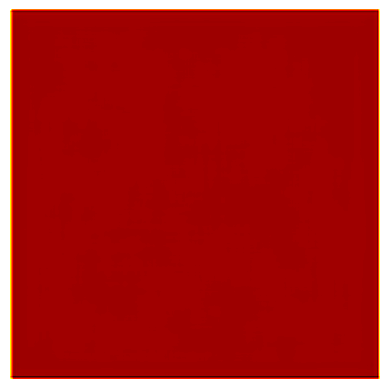

In [4]:
import matplotlib.pyplot as plt

# Ensure we have detached the saliency map and moved it to cpu
sal_map = sal_map.detach().cpu().squeeze()

# As saliency map has values between 0 and 1, we can directly visualize it
plt.imshow(sal_map, cmap='hot')
plt.axis('off')
plt.show()


## train

In [4]:
def train(model, data_loader, epochs=20):
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        for batch, (images, true_saliency_maps) in enumerate(data_loader):
            images = images.to(device)
            true_saliency_maps = true_saliency_maps.to(device)
            print(f"Images Shape: {images.shape}")
            print(f"True Saliency Maps Shape: {true_saliency_maps.shape}")

            print('test1')
            # Forward pass through the encoder and decoder
            encoded = encoder(images)
            print('test1.5')
            print(encoded.shape)
            pred_saliency_maps = decoder(encoded)

            print('test2')
            # Compute the content loss
            content_loss = criterion(pred_saliency_maps, true_saliency_maps)
            
            print('test3')
            # Forward pass through the discriminator
            real_outputs = discriminator(torch.cat([images, true_saliency_maps], dim=1))
            fake_outputs = discriminator(torch.cat([images, pred_saliency_maps.detach()], dim=1))
            
            print('test4')
            # Compute the adversarial loss for the generator
            adv_loss_gen = criterion(fake_outputs, Variable(torch.ones(fake_outputs.size())).to(device))
            
            print('test5')
            # Compute the adversarial loss for the discriminator
            adv_loss_real = criterion(real_outputs, Variable(torch.ones(real_outputs.size())).to(device))
            adv_loss_fake = criterion(fake_outputs, Variable(torch.zeros(fake_outputs.size())).to(device))
            adv_loss_dis = (adv_loss_real + adv_loss_fake) / 2
            
            print('test6')
            # Combine the losses for the generator and perform backpropagation
            gen_loss = content_loss + adv_loss_gen
            encoder.zero_grad()
            decoder.zero_grad()
            gen_loss.backward()
            decoder_optimizer.step()
            encoder_optimizer.step()

            print('test7')
            # Perform backpropagation on the discriminator
            discriminator.zero_grad()
            adv_loss_dis.backward()
            discriminator_optimizer.step()
            
            print(f"Batch {batch+1}/{len(data_loader)}, Content Loss: {content_loss.item()}, Adversarial Loss: {adv_loss_dis.item()}")

        print("Epoch finished!")
        
# Define the model
generator = Generator().to(device)
encoder = generator.encoder
decoder = generator.decoder
discriminator = Discriminator().to(device)

encoder_optimizer = optim.Adagrad(encoder.parameters(), lr=3e-4, weight_decay=1e-4)
decoder_optimizer = optim.Adagrad(decoder.parameters(), lr=3e-4, weight_decay=1e-4)
discriminator_optimizer = optim.Adagrad(discriminator.parameters(), lr=3e-4, weight_decay=1e-4)

criterion = nn.BCELoss()
train(generator, dataloader, epochs=20)


/home/eddieh00/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/eddieh00/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20
Images Shape: torch.Size([1, 3, 256, 256])
True Saliency Maps Shape: torch.Size([1, 1, 256, 256])
test1
test1.5
torch.Size([1, 512, 16, 16])
test2
test3


/home/eddieh00/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:3098: UserWarning: The operator 'aten::binary_cross_entropy' is not currently supported on the DML backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /home/vsts/work/1/s/pytorch-directml-plugin/torch_directml/csrc/dml/dml_cpu_fallback.cpp:15.)
  return torch._C._nn.binary_cross_entropy(input, target, weight, reduction_enum)


RuntimeError: Given groups=1, weight of size [3, 3, 1, 1], expected input[1, 4, 256, 256] to have 3 channels, but got 4 channels instead

In [7]:
images, maps = next(iter(dataloader))

# Move to device
images = images.to(device)

# Forward pass through the encoder
encoded = encoder(images)

print(f"Encoder Output Shape: {encoded.shape}")

print(maps.shape)

Encoder Output Shape: torch.Size([32, 512, 16, 16])
torch.Size([32, 3, 256, 256])


In [7]:

print(decoder)


Sequential(
  (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU()
  (6): Upsample(scale_factor=2.0, mode='nearest')
  (7): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU()
  (9): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU()
  (11): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): ReLU()
  (13): Upsample(scale_factor=2.0, mode='nearest')
  (14): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU()
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU()
  (18): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (19): ReLU()
  (20): Upsample(scale_factor=2.0, mode='nearest')
  (21): Conv2d(256, 128, k

## U-Net Generator 

## Discriminator 

## Loss Functions and Optimizers

## Trainer

## Results